In [2]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection
import os
import pickle
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import datetime
from library.sb_utils import save_file

In [3]:
feature_data = pd.read_csv('../data/jds_features.csv')
feature_data.head()

,match_id,lead_id,agent_id,email_score,phone_score,contact_score,block_score,contact,app
0,40667,12289,174,10.0,62,36.0,47.949,0,0
1,144108,30625,176,95.0,98,96.5,73.384,0,0
2,4314,4446,91,85.0,98,91.5,58.878,0,0
3,89955,20851,228,85.0,99,92.0,55.408,0,0
4,77985,20544,168,85.0,50,67.5,77.282,0,0


In [4]:
feature_data.isnull().any()

match_id         False
lead_id          False
agent_id         False
email_score      False
phone_score      False
contact_score    False
block_score      False
contact          False
app              False
dtype: bool

In [6]:
## Extract contacted leads for model
contacted_leads = feature_data[feature_data['contact'] == 1].copy()
contacted_leads.drop_duplicates(subset = 'lead_id', inplace = True)
contacted_leads.reset_index(drop = True, inplace = True)
print(feature_data.shape)
print(contacted_leads.shape)

(147222, 9)
(18233, 9)


In [7]:
contacted_leads.tail()

,match_id,lead_id,agent_id,email_score,phone_score,contact_score,block_score,contact,app
18228,132655,34142,230,80.0,68,74.0,72.635,1,0
18229,117320,28132,206,80.0,98,89.0,68.594,1,0
18230,28938,11026,192,85.0,92,88.5,57.353,1,0
18231,60304,17635,145,85.0,99,92.0,51.931,1,0
18232,23152,7835,131,60.0,19,39.5,61.039,1,0


In [8]:
contacted_leads.isnull().any()

match_id         False
lead_id          False
agent_id         False
email_score      False
phone_score      False
contact_score    False
block_score      False
contact          False
app              False
dtype: bool

In [9]:
## Remove extra features
non_feature_list = ['match_id', 'lead_id', 'agent_id', 'contact']
contacted_leads_min = contacted_leads.copy()
contacted_leads_min.drop(columns = non_feature_list, inplace = True)
contacted_leads_min

,email_score,phone_score,contact_score,block_score,app
0,80.0,99,89.5,63.033,0
1,85.0,65,75.0,57.398,0
2,85.0,99,92.0,73.182,1
3,95.0,99,97.0,51.631,0
4,30.0,96,63.0,84.483,0
...,...,...,...,...,...
18228,80.0,68,74.0,72.635,0
18229,80.0,98,89.0,68.594,0
18230,85.0,92,88.5,57.353,0
18231,85.0,99,92.0,51.931,0


In [10]:
## Do a 70/30 split for training and testing
len(contacted_leads_min) * .7, len(contacted_leads_min) * .3

(12763.099999999999, 5469.9)

In [11]:
## Split into attributes and labels
X = contacted_leads_min.iloc[:, :-1]
y = contacted_leads_min.iloc[:, 4]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [13]:
X_train.shape, X_test.shape

((12763, 4), (5470, 4))

In [14]:
y_train.shape, y_test.shape

((12763,), (5470,))

In [15]:
X_train.dtypes

email_score      float64
phone_score        int64
contact_score    float64
block_score      float64
dtype: object

In [16]:
X_test.dtypes

email_score      float64
phone_score        int64
contact_score    float64
block_score      float64
dtype: object

In [17]:
## Scale features, though the scores already seem to be out of 100
scaler = StandardScaler()
scaler.fit(X_train)

X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [18]:
X_tr = pd.DataFrame(X_tr_scaled, index = X_train.index, columns = X_train.columns)
X_te = pd.DataFrame(X_te_scaled, index = X_test.index, columns = X_test.columns)

In [19]:
## Test KNN classifier
knn_class = KNeighborsClassifier(n_neighbors = 2)
knn_class.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [20]:
y_pred = knn_class.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [21]:
## Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(cross_val_score(knn_class, X, y, cv=10, scoring='accuracy').mean())

[[5129   19]
 [ 319    3]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5148
           1       0.14      0.01      0.02       322

    accuracy                           0.94      5470
   macro avg       0.54      0.50      0.49      5470
weighted avg       0.89      0.94      0.91      5470

0.9416987181879269


In [22]:
## Pick best K through error analysis
error = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

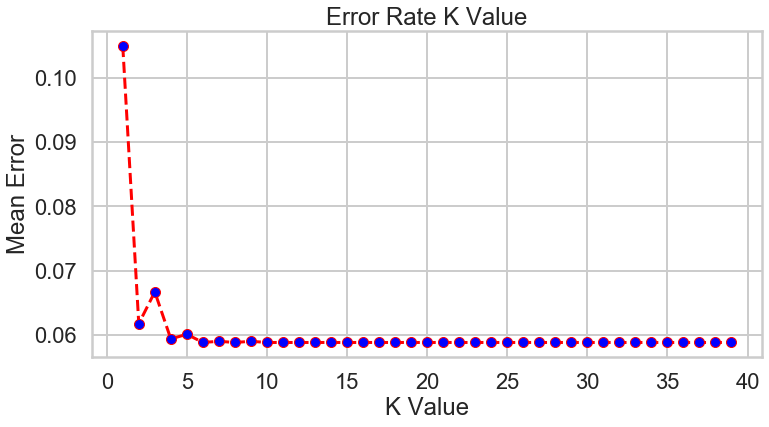

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Looks like a K of 6-40 gives the least mean error, however, too many neighbors would result in overfitting, so I would pick around 3-5 for K.

In [24]:
knn_class = KNeighborsClassifier(n_neighbors = 5)
knn_class.fit(X_train, y_train)
y_pred = knn_class.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(cross_val_score(knn_class, X, y, cv=10, scoring='accuracy').mean())

[[5140    8]
 [ 321    1]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5148
           1       0.11      0.00      0.01       322

    accuracy                           0.94      5470
   macro avg       0.53      0.50      0.49      5470
weighted avg       0.89      0.94      0.91      5470

0.9428509063820776


In [25]:
KNN_pipe = make_pipeline(
    SimpleImputer(strategy = 'median'),
    StandardScaler(),
    KNeighborsClassifier(n_neighbors = 5)
)

In [26]:
## Save model
best_model = KNN_pipe
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [27]:
modelpath = '../models'
save_file(best_model, 'lead_data_prediction_score.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../models\lead_data_prediction_score.pkl"
